In [107]:
import seaborn as sns
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import linear_model
%matplotlib inline
sns.set()

In [108]:
data_sample = pd.read_csv('C:/ongo/DataSample__201709211530.csv')
types = data_sample['type'].unique()
types

for t in types:
    f = lambda x: int(x.replace(',',''))
    # checks if the values contain decimal points, and uses a float conversion if so
    for v in data_sample.loc[data_sample['type'] == t, 'value'].head():
        if '.' in v:
            f = lambda x: float(x.replace(',',''))
            break
    data_sample.loc[data_sample['type'] == t, 'value'] = data_sample.loc[data_sample['type'] == t, 'value'].map(f)
for col in ['startDate', 'endDate', 'createdAt', 'updatedAt']:
    data_sample[col] = pd.to_datetime(data_sample[col], format='%Y-%m-%d %X')
to_tdelta = lambda row: row['endDate'] - row['startDate']
data_sample['duration'] = data_sample.apply(to_tdelta, axis=1)
data_sample['day_of_week'] = data_sample['startDate'].dt.dayofweek
data_sample.head() #0 - 6 is monday - sunday 

,_id,owner,source,sourceId,sourceName,type,startDate,endDate,value,content,originalData,createdAt,updatedAt,duration,day_of_week
0,1ff0fb89-6e1b-4601-84d0-98c79fdc5f2e,00000000-56ff-538b-2223-e1800b5e3ddb,healthkit:com.withings.wiScaleNG,A1DB680E-F9C4-4FA4-8818-1D35E398B5F0,Health Mate,health-bmi,2014-08-27 21:41:23,2014-08-27 21:41:23,26.7387,NaN,NaN,2017-08-31 11:20:49,2017-08-31 11:20:49,0 days,2
1,78219621-1da4-4e3b-87bc-f4885718c63f,00000000-56ff-538b-2223-e1800b5e3ddb,healthkit:com.withings.wiScaleNG,2030515A-1C70-40F3-8470-BDE99ABFC906,Health Mate,health-weight,2014-08-27 21:41:23,2014-08-27 21:41:23,71.042,NaN,NaN,2017-08-31 11:20:58,2017-08-31 11:20:58,0 days,2
2,2d917e7e-0844-4f52-b15e-2a5346c96dda,00000000-56ff-538b-2223-e1800b5e3ddb,healthkit:com.withings.wiScaleNG,96D21A44-67D7-412D-BF3A-543819A8EBF0,Health Mate,health-bmi,2014-08-28 06:24:53,2014-08-28 06:24:53,26.5866,NaN,NaN,2017-08-31 11:20:49,2017-08-31 11:20:49,0 days,3
3,ab800f4b-bef7-434e-8e57-e0fccc44bfb7,00000000-56ff-538b-2223-e1800b5e3ddb,healthkit:com.withings.wiScaleNG,5D73FD9D-17E1-480C-9235-3E5036503E6A,Health Mate,health-body-fat,2014-08-28 06:24:53,2014-08-28 06:24:53,0.258699,NaN,NaN,2017-08-31 11:20:53,2017-08-31 11:20:53,0 days,3
4,fb2a0865-17c3-4ac0-a782-749cc7befe12,00000000-56ff-538b-2223-e1800b5e3ddb,healthkit:com.withings.wiScaleNG,5A9AB03C-30C9-43B9-9742-02E237A6F36D,Health Mate,health-weight,2014-08-28 06:24:53,2014-08-28 06:24:53,70.638,NaN,NaN,2017-08-31 11:20:58,2017-08-31 11:20:58,0 days,3


In [109]:
x1 = data_sample.type
x2 = data_sample.value

types = ['health-bmi','health-body-fat','health-heart-rate','health-sleep','health-weight']
type(x1)

pandas.core.series.Series

In [115]:

data_sample['startDate'] = pd.to_datetime(data_sample['startDate'])

bmi = data_sample[data_sample['type'] == 'health-bmi']
bodyfat = data_sample[data_sample['type'] == 'health-body-fat']


bmi.index = bmi['startDate']
bodyfat.index = bodyfat['startDate']


bmi['value'] = pd.to_numeric(bmi['value'])
bmi = bmi.loc[:,'value']
bmi = bmi.resample('D').mean()


bodyfat['value'] = pd.to_numeric(bodyfat['value'])
bodyfat = bodyfat.loc[:,'value']
bodyfat = bodyfat.resample('D').mean()

bmi = bmi.to_frame('bmi')
bmi['bodyfat'] = bodyfat

bmi


C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,bmi,bodyfat
startDate,,
2014-08-27,26.738682,NaN
2014-08-28,26.648163,0.254151
2014-08-29,26.580980,0.249023
2014-08-30,26.425158,0.250666
2014-08-31,27.029624,0.265226
2014-09-01,27.106090,0.259151
2014-09-02,27.103267,0.241427
2014-09-03,26.683167,0.237895
2014-09-04,26.458281,0.240266


In [116]:
corr_linear = bmi['bmi'].corr(bmi['bodyfat'])
corr_linear

0.53509291331937148

In [117]:
corr_nonlinear = bmi['bmi'].corr(bmi['bodyfat'], method='spearman')
corr_nonlinear

0.78995051603059374

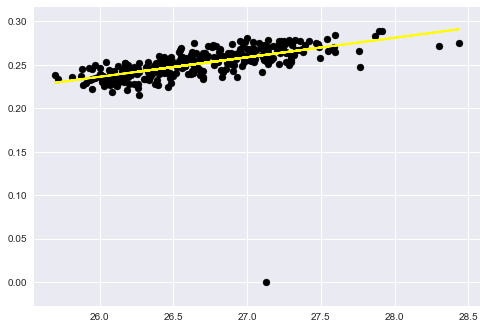

In [118]:
bmi = bmi.dropna()
x = bmi.bmi.values
y = bmi.bodyfat.values
x = x.reshape(len(x), 1)
y = y.reshape(len(x), 1)

regr = linear_model.LinearRegression()
regr.fit(x, y)

# plot it as in the example at http://scikit-learn.org/
plt.scatter(x, y,  color='black')
plt.plot(x, regr.predict(x), color='yellow', linewidth=2)

In [121]:
r_squared = regr.score(x, y)
print ("The r^2 value is {}".format(r_squared))

The r^2 value is 0.286324425885


In [122]:
corr_info = stats.stats.pearsonr(x, y)
r = corr_info[0][0]
p = corr_info[1][0]
print ("The r value is {} and p is {}".format(r, p))

The r value is 0.535092913319 and p is 1.08134572081e-25


In [123]:
x = np.asarray([float(bmi['bmi'][i]) for i in range(len(bmi['bmi']))])
y = np.asarray([float(bmi['bodyfat'][i]) for i in range(len(bmi['bodyfat']))])

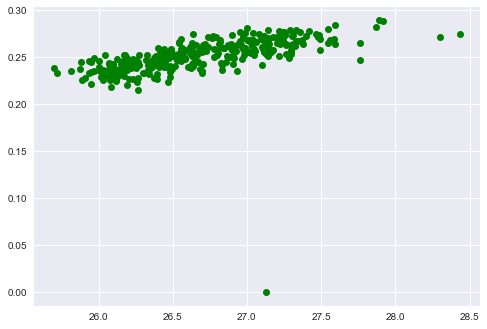

In [124]:
#slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
#line = slope*x+intercept
fit = np.polyfit(x,y,1)
fit_fn = np.poly1d(fit) 
# fit_fn is now a function which takes in x and returns an estimate for y

plt.plot(x,y, 'go') #, x, fit_fn(x), '--k')
#plt.xlim(0, 5)
#plt.ylim(0, 12)